# Problem 14: Head-Dependent Boundary Conditions

### Part b) 
_Model the third type boundary condition as a general head boundary running down the center of column 4. The boundary has the following characteristics:_

| Variable    | Value      |
|-------------|------------|
| Elevation   | 0.0 ft     |
| Conductance | 200 $\frac{ft^2}{d}$ |

_Run the model and note the results as you did in part a._

###  Table 14.1. Aquifer parameters and discretization data for Problem 14
| Variable                     | Value       |
|------------------------------|-------------|
| Initial head                 | 10 ft       |
| Hydraulic conductivity       | 10 $\frac{ft}{d}$     |
| Aquifer base                 | -50 ft      |
| Storage coefficient          | 0.1         |
| Grid spacing (uniform)       | 100 ft      |
| Pumping rate                 | 2500 $\frac{ft^2}{d}$ |
| Stress period length         | 365 days    |
| Time steps                   | 20          |
| Time step multiplier         | 1.2         |
| SIP iteration parameters     | 5           |
| Maximum number of iterations | 50          |
| Acceleration parameter       | 1           |
| Closure criterion            | 0.001       |

In [1]:
#Import and modules/packages that we need to work with
%matplotlib inline
import os
import sys
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
#import csv

In [2]:
print(os.getcwd())
delr = [] #creates an empty list
f = open('../Data/table14.1.csv') #opens the csv file; the two periods (.) means that you are goin backwards into the folders.
    
    #the four loop below creates a statement that if i == 0 (if it's the first
    #row then it will skip it (continue) and move on with the for loop)
    #we skip the first row in our table/csv file because the headers would give
    #us an error since they aren't numerical values.
for i,line in enumerate(f):
    if i == 0: 
        continue
        
    #"line.strip" gets rid of any extra spaces in the margins of the plot
    #"split" sections of the individual values according to whatever you put in the quotes
    linelist = line.strip().split(',') 
    
    value = float(linelist[1]) #changes the values in the list to floats
    print(value) #prints the values
    delr.append(value) #puts the floats into the empty list, delr 
    
print(delr) #prints the list

C:\VT\USGS Internship\modflow_epa.git\Notebooks
10.0
10.0
-50.0
0.1
100.0
2500.0
365.0
20.0
1.2
5.0
50.0
1.0
0.001
[10.0, 10.0, -50.0, 0.1, 100.0, 2500.0, 365.0, 20.0, 1.2, 5.0, 50.0, 1.0, 0.001]


In [3]:
#Store the values of each parameter into separate variables
inh = 10.0 #initial head
hk = 10.0 #hydraulic conductivity
botm = -50.0 #aquifer base
sy = 0.1 #storage coefficient
delr = 100 #grid spacing (uniform)
delc = delr
pr = -2500. #pumping rate
perlen = 365 #final time (stress period length)
nstp = 20 #number of time steps
tsmult = 1.2 #time step multiplier
sip_it_par = 5 #SIP iteration parameters
mxiter = 50 #maximum number of iterations
accel_par = 1.0 #acceleration parameter
hclose = 0.001 #closure criterion (the head change criterion for convergence)
nlay = 1 #number of layers
nrow = 7 #number of rows
ncol = 7 #number of columns

#print values to make sure they are all stored properly
#put in quotes to make a string, .format takes whatever is in the () 
#and changes it to a float, it is then stored in the {}

print('initial head: {} ft'.format(inh))
print('hydraulic conductivity: {} ft/d'.format(hk))
print('aquifer base: {} ft'.format(botm))
print('storage coefficient: {}'.format(sy))
print('grid spacing (uniform): {} ft'.format(delr))
print('pumping rate: {} ft^3/d'.format(pr))
print('stress period length: {} days'.format(perlen))
print('number of time steps: {}'.format(nstp))
print('time step expansion factor: {}'.format(tsmult))
print('SIP iteration parameters: {}'.format(sip_it_par))
print('maximum number of iterations: {}'.format(mxiter))
print('accelereation parameter: {}'.format(accel_par))
print('closure criterion: {}'.format(hclose))


initial head: 10.0 ft
hydraulic conductivity: 10.0 ft/d
aquifer base: -50.0 ft
storage coefficient: 0.1
grid spacing (uniform): 100 ft
pumping rate: -2500.0 ft^3/d
stress period length: 365 days
number of time steps: 20
time step expansion factor: 1.2
SIP iteration parameters: 5
maximum number of iterations: 50
accelereation parameter: 1.0
closure criterion: 0.001


In [4]:
#Flopy objects
modelname = 'p14_pb' #short for problem 14 part b
exe_name = '../MF2005.1_12/bin/mf2005.exe'
model_ws = 'temp'
mf = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws = model_ws)

In [5]:
#call in the discretization package
top = 10 #an array of the top elevation of layer 1
nper = 1 #number of periods
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=top, botm=botm, nper=nper, perlen=perlen, 
                               nstp=nstp, tsmult=tsmult, steady=False)

In [6]:
#call in the basic package
ibound = np.ones((nlay, nrow, ncol))
strt = 10
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

In [7]:
#call in the layer-propery flow (LPF)
laytyp = 1
ipakcb = 50
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, sy=sy, laytyp=laytyp, ipakcb=ipakcb)

In [8]:
#call in the well package (WEL)
# Remember to use zero-based layer, row, column indices!
wel_sp1 = [[0, 0, 0, pr]]
wel_spd = {0: wel_sp1}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_spd)


In [9]:
#call in the preconditioned conjugate-gradient package (PCG) 
pcg = flopy.modflow.ModflowPcg(mf, mxiter=mxiter, hclose=hclose)

In [10]:
#call in the output control package (OC)
oc = flopy.modflow.ModflowOc(mf, stress_period_data={(0, 0): ['save head', 'print budget', 'save budget']})

In [11]:
#call in the general head boundary package (GHB)
ipakcb = 50
ghb_stage = 0.0 
#conductance is equal to hydraulic conductance, times the width of the river, times the length of the river,
#all divided by the riverbed thickness
ghb_cond = (.1 * 20 * 100) / 1
#ghb_sp1 = [[0, 0, 3, ghb_stage, ghb_cond], 
#           [0, 1, 3, ghb_stage, ghb_cond], 
#           [0, 2, 3, ghb_stage, ghb_cond],
#           [0, 3, 3, ghb_stage, ghb_cond], 
#           [0, 4, 3, ghb_stage, ghb_cond], 
#           [0, 5, 3, ghb_stage, ghb_cond], 
#           [0, 6, 3, ghb_stage, ghb_cond]]

#can write in one line
ghb_sp1 = [[0, row, 3, ghb_stage, ghb_cond] for row in range(nrow) ]

ghb_spd = {0: ghb_sp1}
ghb = flopy.modflow.ModflowGhb(mf, ipakcb=ipakcb, stress_period_data=ghb_spd)

print(ghb_sp1)

[[0, 0, 3, 0.0, 200.0], [0, 1, 3, 0.0, 200.0], [0, 2, 3, 0.0, 200.0], [0, 3, 3, 0.0, 200.0], [0, 4, 3, 0.0, 200.0], [0, 5, 3, 0.0, 200.0], [0, 6, 3, 0.0, 200.0]]


In [12]:
[[0, row, 3, ghb_stage, ghb_cond] for row in range(nrow) ]

[[0, 0, 3, 0.0, 200.0],
 [0, 1, 3, 0.0, 200.0],
 [0, 2, 3, 0.0, 200.0],
 [0, 3, 3, 0.0, 200.0],
 [0, 4, 3, 0.0, 200.0],
 [0, 5, 3, 0.0, 200.0],
 [0, 6, 3, 0.0, 200.0]]

In [13]:
# Write the MODFLOW model input files
mf.write_input()

In [14]:
# Run the MODFLOW model
success, buff = mf.run_model()

FloPy is using the following executable to run the model: ../MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: p14_pb.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2017/07/03 12:46:01

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     8    Gro

In [15]:
import flopy.utils.binaryfile as bf

# Create the headfile object
fname = os.path.join(model_ws, 'p14_pb.hds') #"os.path.join" joins together the model_ws and the .hds file and stores it in fname
headobj = bf.HeadFile(fname) #create headobj and put values from fname (aka 'p1_pa.hds') inside it
#times = headobj.get_times() #assign the headobj values to the variable "times"
#print(times) #prints the time at each stress period

#print hydraulic head at node (1, 4) for part a (Table 14.2)
ts = headobj.get_ts([[0, 0, 3]])
print(ts)

[[  1.95513248e+00   8.51035500e+00]
 [  4.30129147e+00   7.53955841e+00]
 [  7.11668205e+00   6.71613359e+00]
 [  1.04951515e+01   5.92555618e+00]
 [  1.45493145e+01   5.12856054e+00]
 [  1.94143105e+01   4.31294441e+00]
 [  2.52523060e+01   3.48044372e+00]
 [  3.22579002e+01   2.64200115e+00]
 [  4.06646156e+01   1.81514466e+00]
 [  5.07526741e+01   1.02176082e+00]
 [  6.28583450e+01   2.85528183e-01]
 [  7.73851471e+01  -3.71194184e-01]
 [  9.48173141e+01  -9.30725336e-01]
 [  1.15735916e+02  -1.38299954e+00]
 [  1.40838242e+02  -1.72731316e+00]
 [  1.70961029e+02  -1.97227108e+00]
 [  2.07108383e+02  -2.13378930e+00]
 [  2.50485199e+02  -2.23165298e+00]
 [  3.02537384e+02  -2.28566837e+00]
 [  3.65000000e+02  -2.31259513e+00]]


In [16]:
import pandas as pd
table2b = pd.read_csv('../Data/table14.2.csv')

table2b.columns #displays all the column names in the file
#drops the columns that you enter into the list
table2b.drop(['River (part a)', 'Drain (part c)', 'E-T (part d)', 'Constant head (part e)'], 
             axis=1, inplace=True)
#prints out the first 5 rows into a table
table2b.head()

,Time Step,Ellapsed Time (days),GHB (part b)
0,1,1.955,8.510
1,2,4.301,7.540
2,3,70117.000,6.716
3,4,10.495,5.926
4,5,14.549,5.129


In [17]:
#prints the whole dataframe instead of just the first 5 rows
print(table2b)

    Time Step  Ellapsed Time (days)  GHB (part b)
0           1                 1.955         8.510
1           2                 4.301         7.540
2           3             70117.000         6.716
3           4                10.495         5.926
4           5                14.549         5.129
5           6                19.414         4.313
6           7                25.252         3.481
7           8                32.258         2.643
8           9                40.655         1.816
9          10                50.753         1.023
10         11                62.858         0.286
11         12                77.385        -0.371
12         13                94.817        -0.930
13         14               115.740        -1.382
14         15               140.840        -1.727
15         16               170.960        -1.972
16         17               207.110        -2.133
17         18               250.490        -2.231
18         19               302.540        -2.285


### Table 14.2. Hydraulic head at node (1,4) for part b representing the third type boundary condition

Check your results to make sure they match with the table from the book

| Time Step | Elapsed Time (days) | GHB (part b) |
|-----------|---------------------|--------------|
| 1         | 1.955               | 8.51         |
| 2         | 4.301               | 7.54         |
| 3         | 7.117               | 6.716        |
| 4         | 10.495              | 5.926        |
| 5         | 14.549              | 5.129        |
| 6         | 19.414              | 4.313        |
| 7         | 25.252              | 3.481        |
| 8         | 32.258              | 2.643        |
| 9         | 40.655              | 1.816        |
| 10        | 50.753              | 1.023        |
| 11        | 62.858              | 0.286        |
| 12        | 77.385              | -0.371       |
| 13        | 94.817              | -0.93        |
| 14        | 115.74              | -1.382       |
| 15        | 140.84              | -1.727       |
| 16        | 170.96              | -1.972       |
| 17        | 207.11              | -2.133       |
| 18        | 250.49              | -2.231       |
| 19        | 302.54              | -2.285       |
| 20        | 365                 | -2.311       |

In [18]:
#print discharge values (Table 14.3)
fname = os.path.join(model_ws, 'p14_pb.cbc')
cbb = flopy.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')[19]
fff = cbb.get_data(text='FLOW FRONT FACE')[19]

ghb_center = cbb.get_data(text='HEAD DEP BOUNDS') #create an array/for loop to get out first value of every step
#cbb.list_records()

#create new list
ghb_list=[]
#dtype tells you what data type ghb_center is
print (ghb_center[0].dtype)
#create for loop to store only the first value of each time step from ghb_center into ghb_list
for ghb in ghb_center:
    ghb_list.append(ghb['q'][0])
    
print(ghb_list)

(numpy.record, [('node', '<i4'), ('q', '<f4')])
[-1702.071, -1507.9116, -1343.2268, -1185.1113, -1025.712, -862.58887, -696.08875, -528.40021, -363.02893, -204.35217, -57.105637, 74.238838, 186.14507, 276.59991, 345.46265, 394.45422, 426.75784, 446.33057, 457.13367, 462.51901]


In [19]:
import pandas as pd
table3b = pd.read_csv('../Data/table14.3.csv')

table3b.columns #displays all the column names in the file
#drops the columns that you enter into the list
table3b.drop(['River (part a)', 'Drain (part c)',
       'E-T (part d)', 'Constant head (part e)'], axis=1, inplace=True)
#prints out the first 5 rows into a table
table3b.head()

,Time Step,Elapsed Time (days),GHB (part b)
0,1,1.955,-1702.071
1,2,4.301,-1507.910
2,3,7.117,-1343.224
3,4,10.495,-1185.109
4,5,14.549,-1025.712


In [20]:
#prints the whole dataframe instead of just the first 5 rows
print(table3b)

    Time Step  Elapsed Time (days)  GHB (part b)
0           1                1.955     -1702.071
1           2                4.301     -1507.910
2           3                7.117     -1343.224
3           4               10.495     -1185.109
4           5               14.549     -1025.712
5           6               19.414      -862.600
6           7               25.252      -696.128
7           8               32.258      -528.506
8           9               40.655      -363.187
9          10               50.753      -204.534
10         11               62.858       -57.278
11         12               77.385        74.103
12         13               94.817       186.031
13         14              115.740       276.494
14         15              140.840       345.353
15         16              170.960       394.344
16         17              207.110       426.648
17         18              250.490       446.221
18         19              302.540       457.037
19         20       

### Table 14.3. Discharge for part b representing the third type boundary condition

Check your results to make sure they match with the table from the book

| Time Step | Elapsed Time (days) | GHB (part b) |
|-----------|---------------------|--------------|
| 1         | 1.955               | -1702.071    |
| 2         | 4.301               | -1507.91     |
| 3         | 7.117               | -1343.224    |
| 4         | 10.495              | -1185.109    |
| 5         | 14.549              | -1025.712    |
| 6         | 19.414              | -862.6       |
| 7         | 25.252              | -696.128     |
| 8         | 32.258              | -528.506     |
| 9         | 40.655              | -363.187     |
| 10        | 50.753              | -204.534     |
| 11        | 62.858              | -57.278      |
| 12        | 77.385              | 74.103       |
| 13        | 94.817              | 186.031      |
| 14        | 115.74              | 276.494      |
| 15        | 140.84              | 345.353      |
| 16        | 170.96              | 394.344      |
| 17        | 207.11              | 426.648      |
| 18        | 250.49              | 446.221      |
| 19        | 302.54              | 457.037      |
| 20        | 365                 | 462.149      |

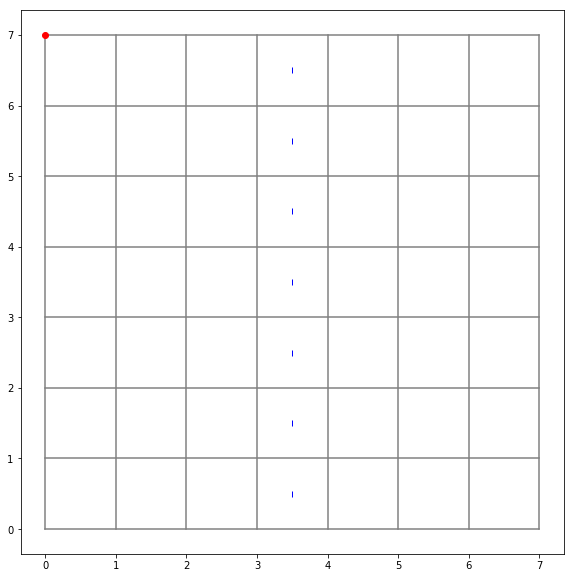

In [21]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ymax = 7
ymin = 0
xmax = ymax #makes xmax equal to ymax which is equal to the sum of the list
xmin = 0
x = 0
y = 0

plt.plot([xmin, xmin], [ymin, ymax], 'gray') #plots the first column line. Must be outside of the loop

for dx in range(0,7): #dx will go through the values in delr one by one in the loop
    x = x + 1 #add the dx value to x, which is zero, and then store that new value into x
    plt.plot([x, x], [ymax, ymin], 'gray') #plot that point and then loop back to top

    #repeat the process above but with the y values to make the rows
plt.plot([xmin, xmax], [ymin, ymin], 'gray') #plots the first row line. Must be outside of the loop

for dy in range(0,7): 
    y = y + 1
    plt.plot([xmin, xmax], [y, y], 'gray')

#create well in top left corner (1, 1)
def plot_well(xmin, ymax, sym):
    plt.plot(xmin, ymax, sym)
plot_well(xmin, ymax, sym='ro')

#create river down mid of col 4
def plot_riv1(xmin, ymax, sym):
    plt.plot(xmin, ymax, sym)
plot_well(xmin + 3.5, ymax=ymax - .5, sym='b|')

def plot_riv1(xmin, ymax, sym):
    plt.plot(xmin, ymax, sym)
plot_well(xmin + 3.5, ymax - 1.5, sym='b|')

def plot_riv1(xmin, ymax, sym):
    plt.plot(xmin, ymax, sym)
plot_well(xmin + 3.5, ymax - 2.5, sym='b|')

def plot_riv1(xmin, ymax, sym):
    plt.plot(xmin, ymax, sym)
plot_well(xmin + 3.5, ymax - 3.5, sym='b|')

def plot_riv1(xmin, ymax, sym):
    plt.plot(xmin, ymax, sym)
plot_well(xmin + 3.5, ymax - 4.5, sym='b|')

def plot_riv1(xmin, ymax, sym):
    plt.plot(xmin, ymax, sym)
plot_well(xmin + 3.5, ymax - 5.5, sym='b|')

def plot_riv1(xmin, ymax, sym):
    plt.plot(xmin, ymax, sym)
plot_well(xmin + 3.5, ymax - 6.5, sym='b|')

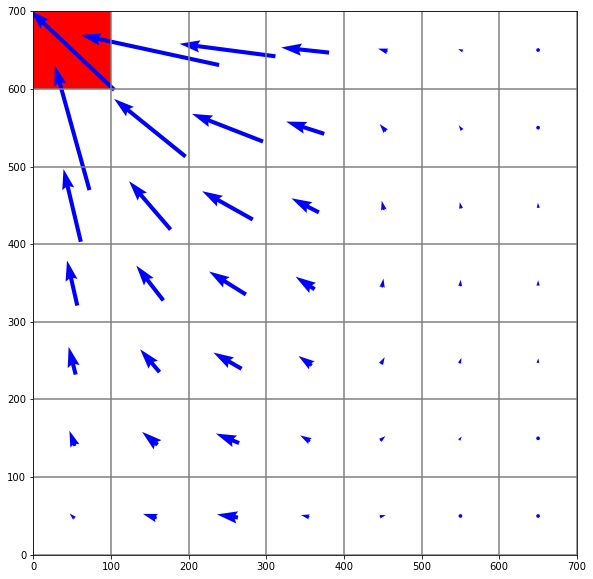

In [22]:
#plot arrows (quivers) that point in the direction of water flowb
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.ModelMap(model=mf)
modelmap.plot_bc("WEL")
quadmesh = modelmap.plot_ibound()
quiver = modelmap.plot_discharge(frf, fff, color='b')
linecollection = modelmap.plot_grid()


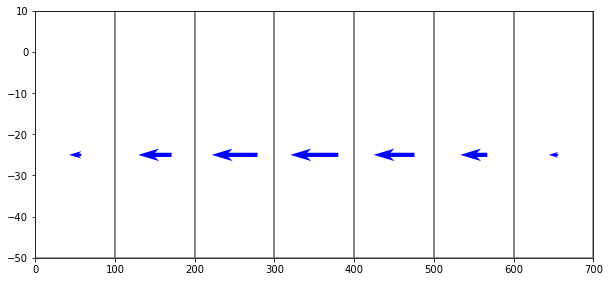

In [23]:
#show plot_array() and plot_discharge()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(2, 1, 1)
modelxsect = flopy.plot.ModelCrossSection(model=mf, ax=ax, line={'Column':6})
linecollection = modelxsect.plot_grid()
quiver = modelxsect.plot_discharge(frf, fff, hstep=1, normalize=False, color='b', headwidth=3, headaxislength=4) 
patches = modelxsect.plot_ibound()

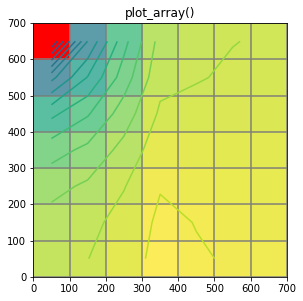

In [31]:
fname = os.path.join(model_ws, 'p14_pb.cbc')
head = headobj.get_data()
levels = np.arange(-10, 0, .5)

fig = plt.figure(figsize=(10, 10))

#plot_array
ax = fig.add_subplot(1, 2, 1, aspect='equal')
ax.set_title('plot_array()')
modelmap = flopy.plot.ModelMap(model=mf)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(head, masked_values=[999.], alpha=0.5)
modelmap.plot_bc("WEL")
linecollection = modelmap.plot_grid()
contour_set = modelmap.contour_array(head, masked_values=[999.], levels=levels)

<a list of 10 text.Text objects>

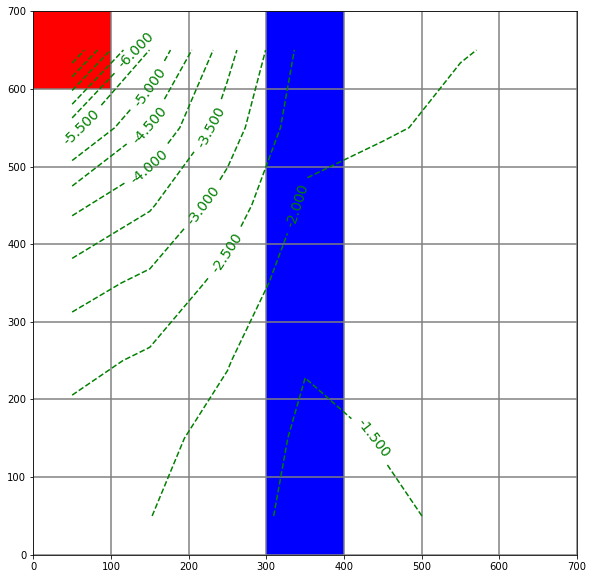

In [34]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=mf)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid()
ghb = modelmap.plot_bc('GHB', color='b', plotAll=True)
quadmesh = modelmap.plot_bc('WEL', kper=1, plotAll=True)
contour_set = modelmap.contour_array(head, levels=np.arange(-10, 0, 0.5), colors='g')
plt.clabel(contour_set, inline=1, fontsize=14)

(0, 365.0)

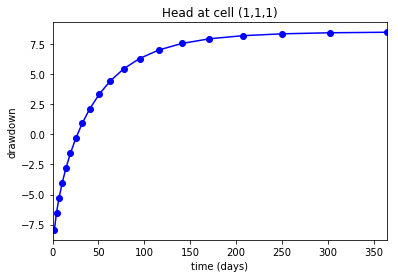

In [26]:
# Plot the drawdown versus time
idx = (0, 0, 0) #(nlay, nrow, ncol) *remember you have to subtract 1 from the original numbers for python - (1, 10, 12)*
ts = headobj.get_ts(idx)
plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1) #we are adding 1 to each part of idx to that it prints out the real values and not the code values
plt.title(ttl) #prints/plots title
plt.xlabel('time (days)') #labels the x-axis
plt.ylabel('drawdown') #labels the y-axis
#here we do "0-ts..." in order to show the drawdown of 
plt.plot(ts[:, 0], 0-ts[:, 1], 'bo-') #(x, y, color/type of line)
plt.xlim(0, ts[:, 0].max())

(0, 365.0)

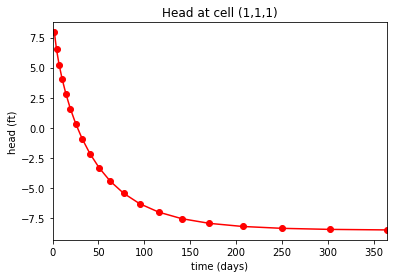

In [27]:
# Plot the head versus time
idx = (0, 0, 0)
ts = headobj.get_ts(idx)
plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1)
plt.title(ttl)
plt.xlabel('time (days)')
plt.ylabel('head (ft)')
plt.plot(ts[:, 0], ts[:, 1], 'ro-')
plt.xlim(0, ts[:, 0].max())

In [33]:
head

array([[[-8.47549057, -5.48540258, -3.66392899, -2.31259513, -2.11504388,
         -2.00954747, -1.96327829],
        [-5.64397621, -4.47004795, -3.25268841, -2.14972138, -2.02465701,
         -1.95165789, -1.91827154],
        [-4.12220049, -3.55145359, -2.76148009, -1.92220354, -1.88376868,
         -1.85551512, -1.84118938],
        [-3.21068764, -2.87756205, -2.33916736, -1.70279932, -1.73420846,
         -1.74683022, -1.75114155],
        [-2.64712262, -2.42144966, -2.0260849 , -1.52668273, -1.60489285,
         -1.64783192, -1.66677046],
        [-2.31556439, -2.14141321, -1.82377064, -1.40685189, -1.51222634,
         -1.5741601 , -1.60266006],
        [-2.16112733, -2.00842094, -1.72515404, -1.34672582, -1.4642967 ,
         -1.53518331, -1.56831145]]], dtype=float32)